### Instructor Demo: Stock Portfolio Forecasting

This program executes `1000` simulations of stock price trajectory for `JNJ` and `MU` over the next `252` trading days (or year of trading), based on a normal probability distribution of potential daily returns derived from the corresponding sample means and standard deviations. Daily and cumulative portfolio returns are then calculated, using `60%` of capital allocated to `JNJ` and `40%` of capital allocated to `MU`, to analyze the probability distribution and confidence interval of potential ending cumulative portfolio returns.

In [17]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [18]:
# Load .env enviroment variables
# from dotenv import load_dotenv
# load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [19]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
# tradeable

In [20]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,NITE
1,AFB
2,CCJ
3,MORT
4,WSFS
5,CRD.B
6,ADBE
7,GBDV
8,PXJ
9,SA


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [21]:
# Set the list of tickers
tickers = ["JNJ", "MU"]

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

JNJ                                       MU  \
                             open    high     low    close   volume   open   
2019-11-19 00:00:00-05:00  135.00  135.19  134.21  134.800  3486534  48.11   
2019-11-20 00:00:00-05:00  135.11  136.34  134.07  135.950  5225319  46.15   
2019-11-21 00:00:00-05:00  135.94  136.85  135.00  136.460  4622714  45.30   
2019-11-22 00:00:00-05:00  136.65  138.63  136.50  138.035  7479788  45.97   
2019-11-25 00:00:00-05:00  137.06  137.65  136.24  137.200  4434132  46.10   

                                                            
                              high    low  close    volume  
2019-11-19 00:00:00-05:00  48.1800  46.28  46.57  17327228  
2019-11-20 00:00:00-05:00  46.5048  45.23  45.55  19568436  
2019-11-21 00:00:00-05:00  46.1800  45.04  45.54  13226127  
2019-11-22 00:00:00-05:00  46.3800  45.75  45.87  10188680  
2019-11-25 00:00:00-05:00  47.5500  45.94  47.54  16882284

### Drop Extraneous Columns

In [22]:
# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

,JNJ,MU
,close,close
2019-11-19 00:00:00-05:00,134.800,46.57
2019-11-20 00:00:00-05:00,135.950,45.55
2019-11-21 00:00:00-05:00,136.460,45.54
2019-11-22 00:00:00-05:00,138.035,45.87
2019-11-25 00:00:00-05:00,137.200,47.54


### Calculate Daily Returns

In [23]:
# Use the `pct_change` function to calculate daily returns of `JNJ` and `MU`.
daily_returns = df.pct_change()
daily_returns.head()

,JNJ,MU
,close,close
2019-11-19 00:00:00-05:00,NaN,NaN
2019-11-20 00:00:00-05:00,0.008531,-0.021903
2019-11-21 00:00:00-05:00,0.003751,-0.000220
2019-11-22 00:00:00-05:00,0.011542,0.007246
2019-11-25 00:00:00-05:00,-0.006049,0.036407


### Calculate Value of Average Daily Returns

In [24]:
# Use the `mean` function to calculate the mean of daily returns for `JNJ` and `MU`, respectively
avg_daily_return_jnj = daily_returns.mean()['JNJ']['close']
avg_daily_return_mu = daily_returns.mean()['MU']['close']
avg_daily_return_mu

0.0013033755972537222

### Calculate Value of Standard Deviation of Daily Returns

In [25]:
# Use the `std` function to calculate the standard deviation of daily returns for `JNJ` and `MU`, respectively
std_dev_daily_return_jnj = daily_returns.std()['JNJ']['close']
std_dev_daily_return_mu = daily_returns.std()['MU']['close']
std_dev_daily_return_mu

0.04616357607031135

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [26]:
# Set number of simulations and trading days
num_simulations = 1000
num_trading_days = 252

# Set last closing prices of `JNJ` and `MU`
jnj_last_price = df['JNJ']['close'][-1]
mu_last_price = df['MU']['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `JNJ` and `MU`
    simulated_jnj_prices = [jnj_last_price]
    simulated_mu_prices = [mu_last_price]
    
    # Simulate the returns for 252 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_jnj_price = simulated_jnj_prices[-1] * (1 + np.random.normal(avg_daily_return_jnj, std_dev_daily_return_jnj))
        simulated_mu_price = simulated_mu_prices[-1] * (1 + np.random.normal(avg_daily_return_mu, std_dev_daily_return_mu))
        
        # Append the simulated price to the list
        simulated_jnj_prices.append(simulated_jnj_price)
        simulated_mu_prices.append(simulated_mu_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["JNJ prices"] = pd.Series(simulated_jnj_prices)
    simulated_price_df["MU prices"] = pd.Series(simulated_mu_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% JNJ; 40% MU)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.987196,1.032553,1.031340,1.031096,0.933968,1.017278,1.026801,0.973861,0.972531,1.007754,...,0.947152,0.972705,0.967845,1.020644,1.005562,1.002547,0.988140,0.998686,0.978058,1.029405
2,1.032558,1.033835,1.045011,1.042443,0.949665,1.029296,1.045076,0.935685,0.968382,0.997836,...,0.897892,0.973242,0.967909,1.044637,1.045661,1.001199,1.004673,1.016762,0.992462,1.015327
3,1.021641,1.041738,1.074710,1.016200,0.934141,1.090135,1.027156,0.963980,1.010322,1.045613,...,0.907345,0.962151,0.977813,1.049054,0.998934,1.009440,0.992340,1.030464,0.989002,0.994217
4,1.034174,1.035038,1.063182,1.022080,0.947367,1.080618,1.043254,0.959509,0.986438,1.025876,...,0.888225,0.986986,0.953250,1.022160,0.999729,0.978068,0.961579,1.000617,0.999290,1.006293


### Plot the Multiple Simulations of Potential Cumulative Portfolio Returns over the Next Year (252 Trading Days)

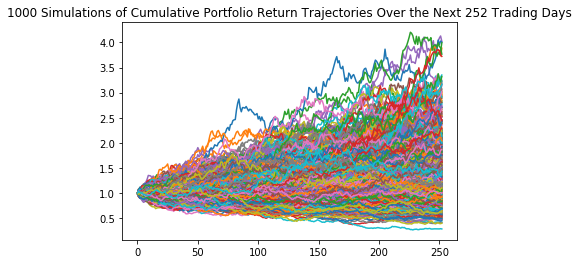

In [27]:
# Use the `plot` function to plot `1000` simulations of the potential trajectories of the portfolio based on 252 trading days
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [28]:
# Select the last row for project stock prices (prices of each simulation on the 252nd trading day)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    1.271881
1    1.159583
2    2.815422
3    1.349690
4    0.827533
Name: 252, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Portfolio Cumulative Returns on the 252nd Trading Day

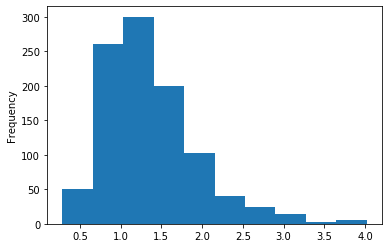

In [29]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
ending_cumulative_returns.plot(kind='hist', bins=10)

### Calculate the Probability Distribution of Ending Cumulative Return Ranges

In [30]:
ending_cumulative_returns.value_counts(bins=11) / len(ending_cumulative_returns)

(0.965, 1.305]                  0.302
(0.625, 0.965]                  0.211
(1.305, 1.644]                  0.193
(1.644, 1.984]                  0.128
(1.984, 2.323]                  0.062
(0.28099999999999997, 0.625]    0.040
(2.323, 2.663]                  0.028
(2.663, 3.002]                  0.019
(3.002, 3.342]                  0.010
(3.682, 4.021]                  0.006
(3.342, 3.682]                  0.001
Name: 252, dtype: float64

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Cumulative Portfolio Returns

In [31]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.025, 0.975])
confidence_interval

0.025    0.583925
0.975    2.815934
Name: 252, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Cumulative Portfolio Returns 

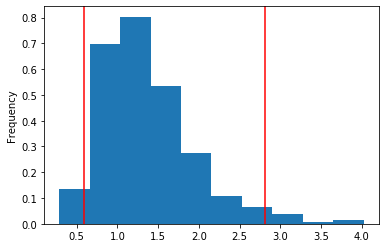

In [32]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in the Portfolio over the Next 252 Trading Days

In [33]:
# Set initial investment
initial_investment = 10000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment + (initial_investment * confidence_interval.iloc[0])
investment_pnl_upper_bound = initial_investment + (initial_investment * confidence_interval.iloc[1])
                                                    
# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 252 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 252 trading days will end within in the range of $15839.252090111479 and $38159.3389144126
